<a href="https://colab.research.google.com/github/Gulshan256/Go-India-Stocks-Python/blob/main/go_india_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from transformers import pipeline
from transformers import BertTokenizer, BertForSequenceClassification
from datetime import datetime
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [82]:
cnbc_url = 'https://www.cnbc.com/search/?query=green%20hydrogen&qsearchterm=green%20hydrogen'
google_news_rss_url = 'https://news.google.com/rss/search?q=green%20hydrogen&hl=en-IN&gl=IN&ceid=IN:en'

In [83]:
# Web scrape CNBC website
def scrape_cnbc(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    headlines = []
    for item in soup.select('.searchResult'):
        headline = item.select_one('.title').get_text(strip=True)
        date_str = item.select_one('.datestamp').get_text(strip=True)
        date = datetime.strptime(date_str, '%B %d, %Y')
        headlines.append({'Date': date, 'Headline': headline, 'Source': 'CNBC'})
    return headlines

In [84]:
# Fetch news headlines from Google News RSS feed
def fetch_google_news_rss(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'xml')
    headlines = []
    for item in soup.find_all('item'):
        headline = item.title.get_text(strip=True)
        date_str = item.pubDate.get_text(strip=True)
        # Remove the time zone information
        date_str = date_str.replace(' GMT', '')
        date = datetime.strptime(date_str, '%a, %d %b %Y %H:%M:%S')
        headlines.append({'Date': date, 'Headline': headline, 'Source': 'Google News'})
    return headlines

In [85]:

def analyze_sentiment(text):
    # print("=====================================================")
    # print(text)
    # model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
    # tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")
    # sentiment_classifier=pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    # model_id = "cardiffnlp/twitter-roberta-base-sentiment-latest"

    # sentiment_classifier = pipeline("sentiment-analysis", model=model_id)

    # # sentiment_classifier = pipeline("sentiment-analysis" , model="siebert/sentiment-roberta-large-english")
    # # sentiment_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")
    # # sentiment_classifier = pipeline("sentiment-analysis", model="ahmedrachid/FinancialBERT-Sentiment-Analysis")

    # result = sentiment_classifier(text)

    model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")
    tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

    nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

    result = nlp(text)
    # print("result ", result)
    return result[0]['label'], result[0]['score']


In [86]:

# Extract organizations using Named Entity Recognition (NER) from Hugging Face
def extract_organizations(text):
    print("start extract_organizations ")
    ner_classifier = pipeline("ner", aggregation_strategy="simple")
    entities = ner_classifier(text)
    print("entities ",entities)
    organizations = [entity['word'] for entity in entities if entity['entity_group'] == 'ORG']
    print("organizations===================== " ,organizations)
    return organizations


In [87]:
# Merge and process data
def merge_and_process_data(cnbc_headlines, google_news_headlines):
    data = cnbc_headlines + google_news_headlines
    df = pd.DataFrame(data)
    df['Sentiment'], df['Sentiment Score'] = zip(*df['Headline'].apply(analyze_sentiment))
    # print("data frame = ",df)
    df['Organizations'] = df['Headline'].apply(extract_organizations)
    return df

In [88]:
# Write data to CSV
def write_to_csv(df, filename):
    df.to_csv(filename, index=False)

# # Write data to Google Sheet
# def write_to_google_sheet(df, sheet_name):
#     scope = ['https://spreadsheets.google.com/feeds',
#              'https://www.googleapis.com/auth/drive']
#     credentials = ServiceAccountCredentials.from_json_keyfile_name('credentials.json', scope)
#     client = gspread.authorize(credentials)
#     sheet = client.create(sheet_name)
#     sheet.share(None, perm_type='anyone', role='reader')
#     worksheet = sheet.get_worksheet(0)
#     for i, col in enumerate(df.columns):
#         worksheet.update_cell(1, i + 1, col)
#     worksheet.update('A2', df.values.tolist())

In [89]:
# Generate week-wise sentiment trend graph
def generate_sentiment_trend_graph(df):
    df['Week'] = df['Date'].dt.strftime('%Y-%U')
    weekly_sentiment = df.groupby('Week')['Sentiment Score'].mean()
    weekly_sentiment.plot(kind='line', figsize=(10, 6))
    plt.xlabel('Week')
    plt.ylabel('Average Sentiment Score')
    plt.title('Week-wise Sentiment Trend')
    plt.grid(True)
    plt.show()


In [90]:
# Generate word cloud for organizations mentioned in headlines
def generate_wordcloud(df):
    organizations_list = df['Organizations'].sum()
    wordcloud_text = ' '.join(organizations_list)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Organizations Mentioned in Headlines')
    plt.show()

In [91]:
# Main function
def main():
    cnbc_url = 'https://www.cnbc.com/search/?query=green%20hydrogen&qsearchterm=green%20hydrogen'
    google_news_rss_url = 'https://news.google.com/rss/search?q=green%20hydrogen&hl=en-IN&gl=IN&ceid=IN:en'

    # Web scrape CNBC and Google News
    cnbc_headlines = scrape_cnbc(cnbc_url)
    google_news_headlines = fetch_google_news_rss(google_news_rss_url)

    # Merge and process data
    df = merge_and_process_data(cnbc_headlines, google_news_headlines)

    # Write data to CSV
    write_to_csv(df, 'green_hydrogen_news.csv')

    # Write data to Google Sheet
    # write_to_google_sheet(df, 'Green Hydrogen News')

    # Generate sentiment trend graph
    generate_sentiment_trend_graph(df)

    # Generate word cloud
    generate_wordcloud(df)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.97656757, 'word': 'ETEnergyWorld', 'start': 80, 'end': 93}]
organizations=====================  ['ETEnergyWorld']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9826861, 'word': 'MNRE', 'start': 0, 'end': 4}, {'entity_group': 'ORG', 'score': 0.7109181, 'word': 'Steel Industry', 'start': 60, 'end': 74}, {'entity_group': 'ORG', 'score': 0.9850172, 'word': 'Mercom India', 'start': 77, 'end': 89}]
organizations=====================  ['MNRE', 'Steel Industry', 'Mercom India']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'MISC', 'score': 0.44470602, 'word': 'India', 'start': 0, 'end': 5}, {'entity_group': 'MISC', 'score': 0.6432626, 'word': 'La', 'start': 30, 'end': 32}, {'entity_group': 'ORG', 'score': 0.9357451, 'word': 'SolarQuarter', 'start': 101, 'end': 113}]
organizations=====================  ['SolarQuarter']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'MISC', 'score': 0.48212275, 'word': 'India', 'start': 0, 'end': 5}, {'entity_group': 'ORG', 'score': 0.71684974, 'word': 'Energy', 'start': 6, 'end': 12}, {'entity_group': 'MISC', 'score': 0.9508172, 'word': 'Week', 'start': 13, 'end': 17}, {'entity_group': 'PER', 'score': 0.9174095, 'word': 'Modi', 'start': 19, 'end': 23}, {'entity_group': 'ORG', 'score': 0.9087408, 'word': '##control', 'start': 95, 'end': 102}]
organizations=====================  ['Energy', '##control']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9994828, 'word': 'Reliance Industries', 'start': 21, 'end': 40}, {'entity_group': 'ORG', 'score': 0.8236053, 'word': 'ICE', 'start': 66, 'end': 69}, {'entity_group': 'LOC', 'score': 0.58037245, 'word': 'India', 'start': 128, 'end': 133}]
organizations=====================  ['Reliance Industries', 'ICE']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.98485357, 'word': 'ETEnergyWorld', 'start': 82, 'end': 95}]
organizations=====================  ['ETEnergyWorld']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9920554, 'word': 'Envision Energy', 'start': 0, 'end': 15}, {'entity_group': 'ORG', 'score': 0.9991234, 'word': 'BASF', 'start': 30, 'end': 34}, {'entity_group': 'ORG', 'score': 0.6474427, 'word': 'Green', 'start': 44, 'end': 49}, {'entity_group': 'ORG', 'score': 0.6396337, 'word': '##gen Development', 'start': 55, 'end': 70}, {'entity_group': 'ORG', 'score': 0.903819, 'word': 'SolarQuarter', 'start': 105, 'end': 117}]
organizations=====================  ['Envision Energy', 'BASF', 'Green', '##gen Development', 'SolarQuarter']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  []
organizations=====================  []
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9956155, 'word': 'Oil India', 'start': 61, 'end': 70}, {'entity_group': 'ORG', 'score': 0.9981034, 'word': 'NDTV', 'start': 85, 'end': 89}]
organizations=====================  ['Oil India', 'NDTV']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.98067135, 'word': 'World Economic Forum', 'start': 59, 'end': 79}, {'entity_group': 'ORG', 'score': 0.99409467, 'word': 'World Economic Forum', 'start': 82, 'end': 102}]
organizations=====================  ['World Economic Forum', 'World Economic Forum']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.99642676, 'word': 'Mangaluru', 'start': 0, 'end': 9}, {'entity_group': 'PER', 'score': 0.9987473, 'word': 'K J George', 'start': 86, 'end': 96}, {'entity_group': 'ORG', 'score': 0.89003086, 'word': 'Daijiworld. com', 'start': 99, 'end': 113}]
organizations=====================  ['Daijiworld. com']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'MISC', 'score': 0.7866447, 'word': 'Fuel Cell', 'start': 23, 'end': 32}, {'entity_group': 'LOC', 'score': 0.990918, 'word': 'India', 'start': 84, 'end': 89}, {'entity_group': 'MISC', 'score': 0.5263778, 'word': 'Rene', 'start': 92, 'end': 96}, {'entity_group': 'ORG', 'score': 0.85941285, 'word': 'CXOToday', 'start': 118, 'end': 126}, {'entity_group': 'ORG', 'score': 0.6038382, 'word': 'com', 'start': 127, 'end': 130}]
organizations=====================  ['CXOToday', 'com']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.9996947, 'word': 'India', 'start': 0, 'end': 5}, {'entity_group': 'MISC', 'score': 0.652457, 'word': 'Contract', 'start': 16, 'end': 24}, {'entity_group': 'MISC', 'score': 0.5779858, 'word': 'Di', 'start': 29, 'end': 31}, {'entity_group': 'ORG', 'score': 0.9843049, 'word': 'Hydrogen Insight', 'start': 82, 'end': 98}]
organizations=====================  ['Hydrogen Insight']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.9215985, 'word': 'India', 'start': 10, 'end': 15}, {'entity_group': 'MISC', 'score': 0.73889995, 'word': 'Green H', 'start': 18, 'end': 25}, {'entity_group': 'MISC', 'score': 0.7428474, 'word': '##gen Revolution', 'start': 29, 'end': 43}, {'entity_group': 'LOC', 'score': 0.9918847, 'word': 'India', 'start': 46, 'end': 51}]
organizations=====================  []
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.9991486, 'word': 'India', 'start': 0, 'end': 5}, {'entity_group': 'LOC', 'score': 0.9812775, 'word': 'Asia Pacific', 'start': 88, 'end': 100}, {'entity_group': 'ORG', 'score': 0.9453249, 'word': 'Energetica India', 'start': 103, 'end': 119}]
organizations=====================  ['Energetica India']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9970182, 'word': 'SCI', 'start': 0, 'end': 3}, {'entity_group': 'MISC', 'score': 0.8083235, 'word': 'Green H', 'start': 10, 'end': 17}, {'entity_group': 'MISC', 'score': 0.82240707, 'word': '##gen Initiative', 'start': 21, 'end': 35}, {'entity_group': 'ORG', 'score': 0.64434266, 'word': 'Construction', 'start': 38, 'end': 50}, {'entity_group': 'MISC', 'score': 0.77247614, 'word': 'World', 'start': 51, 'end': 56}]
organizations=====================  ['SCI', 'Construction']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9934081, 'word': 'Advait Infratech Limited', 'start': 0, 'end': 24}, {'entity_group': 'LOC', 'score': 0.9947661, 'word': 'India', 'start': 36, 'end': 41}, {'entity_group': 'MISC', 'score': 0.49192712, 'word': 'First', 'start': 44, 'end': 49}, {'entity_group': 'LOC', 'score': 0.44628534, 'word': '##CIL', 'start': 81, 'end': 84}, {'entity_group': 'LOC', 'score': 0.9906898, 'word': 'Rishikesh', 'start': 86, 'end': 95}, {'entity_group': 'ORG', 'score': 0.6863025, 'word': 'CXOToday', 'start': 98, 'end': 106}]
organizations=====================  ['Advait Infratech Limited', 'CXOToday']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'MISC', 'score': 0.8897489, 'word': 'Green H', 'start': 57, 'end': 64}, {'entity_group': 'MISC', 'score': 0.9502067, 'word': '##gen', 'start': 68, 'end': 71}, {'entity_group': 'MISC', 'score': 0.91915035, 'word': 'Business Standard', 'start': 74, 'end': 91}]
organizations=====================  []
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9989786, 'word': 'BASF', 'start': 0, 'end': 4}, {'entity_group': 'ORG', 'score': 0.99336076, 'word': 'Envision Energy', 'start': 9, 'end': 24}, {'entity_group': 'ORG', 'score': 0.94470745, 'word': 'ChemAnalyst', 'start': 90, 'end': 101}]
organizations=====================  ['BASF', 'Envision Energy', 'ChemAnalyst']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.8562622, 'word': 'IndiaTimes', 'start': 93, 'end': 103}]
organizations=====================  ['IndiaTimes']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'PER', 'score': 0.9982162, 'word': 'RK Singh', 'start': 15, 'end': 23}, {'entity_group': 'ORG', 'score': 0.9895325, 'word': 'DD News', 'start': 73, 'end': 80}]
organizations=====================  ['DD News']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9965162, 'word': 'IIPE', 'start': 0, 'end': 4}, {'entity_group': 'LOC', 'score': 0.98588085, 'word': 'Visakhapatnam', 'start': 8, 'end': 21}, {'entity_group': 'ORG', 'score': 0.99481535, 'word': 'NTPC', 'start': 79, 'end': 83}, {'entity_group': 'ORG', 'score': 0.9915719, 'word': 'The Hindu', 'start': 106, 'end': 115}]
organizations=====================  ['IIPE', 'NTPC', 'The Hindu']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.9998006, 'word': 'Brazil', 'start': 0, 'end': 6}, {'entity_group': 'ORG', 'score': 0.99845594, 'word': 'Petrobras', 'start': 9, 'end': 18}, {'entity_group': 'ORG', 'score': 0.92860883, 'word': 'Renewables Now', 'start': 63, 'end': 77}]
organizations=====================  ['Petrobras', 'Renewables Now']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.6680263, 'word': 'Wood', 'start': 0, 'end': 4}]
organizations=====================  ['Wood']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.99939406, 'word': 'Texas', 'start': 68, 'end': 73}, {'entity_group': 'ORG', 'score': 0.9943087, 'word': 'ETN News', 'start': 76, 'end': 84}]
organizations=====================  ['ETN News']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9856685, 'word': 'MNRE', 'start': 0, 'end': 4}, {'entity_group': 'ORG', 'score': 0.96150553, 'word': 'Construction World', 'start': 57, 'end': 75}]
organizations=====================  ['MNRE', 'Construction World']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.8377865, 'word': 'Hydrogen Insight', 'start': 118, 'end': 134}]
organizations=====================  ['Hydrogen Insight']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.9898672, 'word': 'India', 'start': 0, 'end': 5}, {'entity_group': 'LOC', 'score': 0.99793774, 'word': 'India', 'start': 22, 'end': 27}, {'entity_group': 'ORG', 'score': 0.99795276, 'word': 'Tata Power', 'start': 82, 'end': 92}, {'entity_group': 'LOC', 'score': 0.72190595, 'word': 'Asia', 'start': 100, 'end': 104}, {'entity_group': 'ORG', 'score': 0.8532226, 'word': 'SolarQuarter', 'start': 121, 'end': 133}]
organizations=====================  ['Tata Power', 'SolarQuarter']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.89766663, 'word': 'Elets', 'start': 92, 'end': 97}, {'entity_group': 'ORG', 'score': 0.94335127, 'word': 'Elets', 'start': 105, 'end': 110}]
organizations=====================  ['Elets', 'Elets']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.999342, 'word': 'India', 'start': 0, 'end': 5}, {'entity_group': 'MISC', 'score': 0.885251, 'word': 'India Energy Week', 'start': 60, 'end': 77}, {'entity_group': 'ORG', 'score': 0.51172066, 'word': '##control', 'start': 85, 'end': 92}]
organizations=====================  ['##control']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.99968684, 'word': 'Japan', 'start': 0, 'end': 5}, {'entity_group': 'ORG', 'score': 0.9912511, 'word': 'SolarPACES', 'start': 77, 'end': 87}]
organizations=====================  ['SolarPACES']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'MISC', 'score': 0.7699112, 'word': 'Stream', 'start': 13, 'end': 19}, {'entity_group': 'LOC', 'score': 0.99881446, 'word': 'India', 'start': 21, 'end': 26}, {'entity_group': 'ORG', 'score': 0.5074244, 'word': 'India', 'start': 130, 'end': 135}]
organizations=====================  ['India']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.7565351, 'word': '##l', 'start': 97, 'end': 98}]
organizations=====================  ['##l']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.99595094, 'word': 'Press Information Bureau', 'start': 0, 'end': 24}, {'entity_group': 'ORG', 'score': 0.9948493, 'word': 'PIB', 'start': 27, 'end': 30}]
organizations=====================  ['Press Information Bureau', 'PIB']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.983377, 'word': 'EU', 'start': 0, 'end': 2}, {'entity_group': 'ORG', 'score': 0.9271776, 'word': 'Naturgy', 'start': 19, 'end': 26}, {'entity_group': 'ORG', 'score': 0.9263951, 'word': 'Enagas', 'start': 31, 'end': 37}, {'entity_group': 'MISC', 'score': 0.65461767, 'word': 'Joint Green', 'start': 42, 'end': 53}, {'entity_group': 'MISC', 'score': 0.4758595, 'word': '##gen', 'start': 59, 'end': 62}, {'entity_group': 'LOC', 'score': 0.99910444, 'word': 'Spain', 'start': 74, 'end': 79}, {'entity_group': 'ORG', 'score': 0.93733644, 'word': 'ChemAnalyst', 'start': 82, 'end': 93}]
organizations=====================  ['EU', 'Naturgy', 'Enagas', 'ChemAnalyst']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.86474264, 'word': 'Mint', 'start': 117, 'end': 121}, {'entity_group': 'ORG', 'score': 0.8874564, 'word': 'Mint', 'start': 124, 'end': 128}]
organizations=====================  ['Mint', 'Mint']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.96000797, 'word': 'MNRE', 'start': 20, 'end': 24}, {'entity_group': 'ORG', 'score': 0.81270444, 'word': 'Steel Industry', 'start': 56, 'end': 70}, {'entity_group': 'ORG', 'score': 0.97028774, 'word': 'Mercom India', 'start': 73, 'end': 85}]
organizations=====================  ['MNRE', 'Steel Industry', 'Mercom India']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.97483075, 'word': 'Tech Xplore', 'start': 92, 'end': 103}]
organizations=====================  ['Tech Xplore']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'MISC', 'score': 0.5119374, 'word': 'Green', 'start': 27, 'end': 32}, {'entity_group': 'ORG', 'score': 0.7816314, 'word': '##control', 'start': 80, 'end': 87}]
organizations=====================  ['##control']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9730199, 'word': 'NGEL', 'start': 0, 'end': 4}, {'entity_group': 'LOC', 'score': 0.89551294, 'word': 'Maharashtra', 'start': 19, 'end': 30}, {'entity_group': 'ORG', 'score': 0.92364776, 'word': 'SolarQuarter', 'start': 83, 'end': 95}]
organizations=====================  ['NGEL', 'SolarQuarter']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.6961567, 'word': 'MNRE', 'start': 73, 'end': 77}, {'entity_group': 'ORG', 'score': 0.97396857, 'word': 'ETEnergyWorld', 'start': 80, 'end': 93}]
organizations=====================  ['MNRE', 'ETEnergyWorld']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.9995427, 'word': 'India', 'start': 0, 'end': 5}, {'entity_group': 'LOC', 'score': 0.9180609, 'word': 'India', 'start': 68, 'end': 73}]
organizations=====================  []
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.9996556, 'word': 'India', 'start': 0, 'end': 5}]
organizations=====================  []
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9966026, 'word': 'MNRE', 'start': 0, 'end': 4}, {'entity_group': 'MISC', 'score': 0.838924, 'word': 'Green', 'start': 55, 'end': 60}, {'entity_group': 'MISC', 'score': 0.7771399, 'word': '##gen', 'start': 66, 'end': 69}, {'entity_group': 'ORG', 'score': 0.83192325, 'word': 'CNBCTV18', 'start': 88, 'end': 96}]
organizations=====================  ['MNRE', 'CNBCTV18']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9985358, 'word': 'Oracle Power', 'start': 0, 'end': 12}, {'entity_group': 'LOC', 'score': 0.9963766, 'word': 'Pakistan', 'start': 51, 'end': 59}, {'entity_group': 'ORG', 'score': 0.990256, 'word': 'Hydrogen Central', 'start': 85, 'end': 101}]
organizations=====================  ['Oracle Power', 'Hydrogen Central']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.92936254, 'word': 'Asia Pacific', 'start': 78, 'end': 90}, {'entity_group': 'ORG', 'score': 0.9550252, 'word': 'Energetica India', 'start': 93, 'end': 109}]
organizations=====================  ['Energetica India']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'MISC', 'score': 0.8275731, 'word': 'Indian', 'start': 29, 'end': 35}, {'entity_group': 'ORG', 'score': 0.7924546, 'word': 'Steel', 'start': 36, 'end': 41}, {'entity_group': 'ORG', 'score': 0.8970107, 'word': 'SolarQuarter', 'start': 100, 'end': 112}]
organizations=====================  ['Steel', 'SolarQuarter']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.99308205, 'word': 'Offshore Energy', 'start': 81, 'end': 96}]
organizations=====================  ['Offshore Energy']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9941222, 'word': 'Tecnimont', 'start': 0, 'end': 9}, {'entity_group': 'ORG', 'score': 0.9940409, 'word': 'MAIRE', 'start': 11, 'end': 16}, {'entity_group': 'LOC', 'score': 0.99923, 'word': 'Portugal', 'start': 111, 'end': 119}, {'entity_group': 'ORG', 'score': 0.9869953, 'word': 'World Fertilizer', 'start': 122, 'end': 138}]
organizations=====================  ['Tecnimont', 'MAIRE', 'World Fertilizer']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.97219163, 'word': 'ETAuto', 'start': 54, 'end': 60}]
organizations=====================  ['ETAuto']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9863342, 'word': 'ETEnergyWorld', 'start': 74, 'end': 87}]
organizations=====================  ['ETEnergyWorld']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9925797, 'word': 'Innovators Magazine', 'start': 67, 'end': 86}]
organizations=====================  ['Innovators Magazine']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'PER', 'score': 0.99774927, 'word': 'Wood', 'start': 0, 'end': 4}, {'entity_group': 'LOC', 'score': 0.99970454, 'word': 'Spain', 'start': 78, 'end': 83}, {'entity_group': 'ORG', 'score': 0.9976931, 'word': 'OGV Energy', 'start': 86, 'end': 96}]
organizations=====================  ['OGV Energy']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9972356, 'word': 'The Economic Times', 'start': 46, 'end': 64}]
organizations=====================  ['The Economic Times']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9837705, 'word': 'Green Hydrogen Mission', 'start': 0, 'end': 22}, {'entity_group': 'ORG', 'score': 0.9938198, 'word': 'The Economic Times', 'start': 81, 'end': 99}]
organizations=====================  ['Green Hydrogen Mission', 'The Economic Times']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.9997129, 'word': 'India', 'start': 0, 'end': 5}, {'entity_group': 'ORG', 'score': 0.98745006, 'word': 'Offshore Energy', 'start': 67, 'end': 82}]
organizations=====================  ['Offshore Energy']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.97519135, 'word': 'ThePrint', 'start': 93, 'end': 101}]
organizations=====================  ['ThePrint']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.68790054, 'word': 'ANALYSI', 'start': 0, 'end': 7}, {'entity_group': 'ORG', 'score': 0.9967609, 'word': 'EU', 'start': 21, 'end': 23}, {'entity_group': 'ORG', 'score': 0.5910566, 'word': 'H', 'start': 97, 'end': 98}, {'entity_group': 'ORG', 'score': 0.8876712, 'word': '##gen Insight', 'start': 102, 'end': 113}]
organizations=====================  ['ANALYSI', 'EU', 'H', '##gen Insight']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9982369, 'word': 'Kraft Heinz', 'start': 0, 'end': 11}, {'entity_group': 'LOC', 'score': 0.74850047, 'word': 'Maiden Green', 'start': 32, 'end': 44}, {'entity_group': 'LOC', 'score': 0.9638724, 'word': 'UK', 'start': 71, 'end': 73}, {'entity_group': 'ORG', 'score': 0.9339326, 'word': 'ChemAnalyst', 'start': 87, 'end': 98}]
organizations=====================  ['Kraft Heinz', 'ChemAnalyst']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.99608755, 'word': 'Gujarat', 'start': 1, 'end': 8}, {'entity_group': 'ORG', 'score': 0.99723125, 'word': 'Times of India', 'start': 45, 'end': 59}]
organizations=====================  ['Times of India']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.92717355, 'word': 'Business Today', 'start': 97, 'end': 111}]
organizations=====================  ['Business Today']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.99312747, 'word': 'NTPC Green Energy', 'start': 0, 'end': 17}, {'entity_group': 'LOC', 'score': 0.9989668, 'word': 'Maharashtra', 'start': 43, 'end': 54}, {'entity_group': 'ORG', 'score': 0.7182987, 'word': 'Mint', 'start': 66, 'end': 70}, {'entity_group': 'ORG', 'score': 0.8350043, 'word': 'Mint', 'start': 73, 'end': 77}]
organizations=====================  ['NTPC Green Energy', 'Mint', 'Mint']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.99552757, 'word': 'Hindustan Times', 'start': 93, 'end': 108}]
organizations=====================  ['Hindustan Times']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.99755216, 'word': 'MNRE', 'start': 0, 'end': 4}, {'entity_group': 'MISC', 'score': 0.5617736, 'word': 'Standard', 'start': 80, 'end': 88}]
organizations=====================  ['MNRE']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.95796585, 'word': 'Steel and Port Ministries', 'start': 0, 'end': 25}, {'entity_group': 'ORG', 'score': 0.96607375, 'word': 'BusinessLine', 'start': 75, 'end': 87}]
organizations=====================  ['Steel and Port Ministries', 'BusinessLine']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.980344, 'word': 'ReNew', 'start': 0, 'end': 5}, {'entity_group': 'LOC', 'score': 0.99726593, 'word': 'Kerala', 'start': 71, 'end': 77}, {'entity_group': 'ORG', 'score': 0.97270644, 'word': 'ETEnergyWorld', 'start': 80, 'end': 93}]
organizations=====================  ['ReNew', 'ETEnergyWorld']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.99370295, 'word': 'India', 'start': 0, 'end': 5}, {'entity_group': 'ORG', 'score': 0.6303588, 'word': 'Steel', 'start': 83, 'end': 88}, {'entity_group': 'MISC', 'score': 0.40455693, 'word': 'Sector', 'start': 89, 'end': 95}, {'entity_group': 'ORG', 'score': 0.9827044, 'word': 'Hydrogen Central', 'start': 98, 'end': 114}]
organizations=====================  ['Steel', 'Hydrogen Central']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9925394, 'word': 'NTPC Green Energy', 'start': 0, 'end': 17}, {'entity_group': 'LOC', 'score': 0.7545804, 'word': 'Maharashtra', 'start': 32, 'end': 43}, {'entity_group': 'ORG', 'score': 0.6575511, 'word': 'Govt', 'start': 44, 'end': 48}, {'entity_group': 'ORG', 'score': 0.9556178, 'word': 'ETEnergyWorld', 'start': 99, 'end': 112}]
organizations=====================  ['NTPC Green Energy', 'Govt', 'ETEnergyWorld']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9057358, 'word': 'Moneycontrol', 'start': 67, 'end': 79}]
organizations=====================  ['Moneycontrol']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.9929285, 'word': 'Abu Dhabi', 'start': 0, 'end': 9}, {'entity_group': 'ORG', 'score': 0.99042207, 'word': 'Department Of Economic Development', 'start': 10, 'end': 44}, {'entity_group': 'ORG', 'score': 0.9802084, 'word': 'HYCAP Group', 'start': 49, 'end': 60}, {'entity_group': 'ORG', 'score': 0.96069986, 'word': 'SolarQuarter', 'start': 106, 'end': 118}]
organizations=====================  ['Department Of Economic Development', 'HYCAP Group', 'SolarQuarter']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.9993542, 'word': 'India', 'start': 0, 'end': 5}, {'entity_group': 'MISC', 'score': 0.54506516, 'word': 'Sector', 'start': 61, 'end': 67}, {'entity_group': 'ORG', 'score': 0.7509808, 'word': 'SolarQuarter', 'start': 93, 'end': 105}]
organizations=====================  ['SolarQuarter']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'MISC', 'score': 0.9989293, 'word': 'Swiss', 'start': 0, 'end': 5}, {'entity_group': 'ORG', 'score': 0.95002115, 'word': 'Hydrogen Insight', 'start': 100, 'end': 116}]
organizations=====================  ['Hydrogen Insight']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'MISC', 'score': 0.68516034, 'word': 'Green', 'start': 68, 'end': 73}, {'entity_group': 'MISC', 'score': 0.6686251, 'word': '##gen', 'start': 79, 'end': 82}, {'entity_group': 'ORG', 'score': 0.991775, 'word': 'The Economic Times', 'start': 85, 'end': 103}]
organizations=====================  ['The Economic Times']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.9984188, 'word': 'Maharashtra', 'start': 0, 'end': 11}]
organizations=====================  []
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.3458357, 'word': 'Steel', 'start': 59, 'end': 64}, {'entity_group': 'MISC', 'score': 0.5729113, 'word': 'Sector', 'start': 65, 'end': 71}, {'entity_group': 'ORG', 'score': 0.9651061, 'word': 'Construction World', 'start': 74, 'end': 92}]
organizations=====================  ['Steel', 'Construction World']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'MISC', 'score': 0.5702806, 'word': 'Green', 'start': 36, 'end': 41}, {'entity_group': 'ORG', 'score': 0.9943632, 'word': 'Construction World', 'start': 72, 'end': 90}]
organizations=====================  ['Construction World']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.98941255, 'word': 'THDC', 'start': 0, 'end': 4}, {'entity_group': 'LOC', 'score': 0.9987087, 'word': 'Uttarakhand', 'start': 58, 'end': 69}, {'entity_group': 'ORG', 'score': 0.6554533, 'word': 'Sustainable Energy', 'start': 82, 'end': 100}, {'entity_group': 'ORG', 'score': 0.8668293, 'word': 'SolarQuarter', 'start': 113, 'end': 125}]
organizations=====================  ['THDC', 'Sustainable Energy', 'SolarQuarter']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'MISC', 'score': 0.8864984, 'word': 'India', 'start': 49, 'end': 54}, {'entity_group': 'LOC', 'score': 0.5286561, 'word': 'India', 'start': 57, 'end': 62}]
organizations=====================  []
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.99959475, 'word': 'Jordan', 'start': 0, 'end': 6}, {'entity_group': 'MISC', 'score': 0.69449496, 'word': 'Green', 'start': 38, 'end': 43}, {'entity_group': 'MISC', 'score': 0.63526833, 'word': '##gen', 'start': 49, 'end': 52}, {'entity_group': 'ORG', 'score': 0.9374778, 'word': 'SolarQuarter', 'start': 83, 'end': 95}]
organizations=====================  ['SolarQuarter']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9961324, 'word': 'MNRE', 'start': 0, 'end': 4}, {'entity_group': 'ORG', 'score': 0.9987655, 'word': 'Press Trust of India', 'start': 90, 'end': 110}]
organizations=====================  ['MNRE', 'Press Trust of India']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9941514, 'word': 'JSW Neo Energy', 'start': 0, 'end': 14}, {'entity_group': 'ORG', 'score': 0.979922, 'word': 'Manufacturing Today India', 'start': 62, 'end': 87}]
organizations=====================  ['JSW Neo Energy', 'Manufacturing Today India']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9837027, 'word': 'SCI', 'start': 20, 'end': 23}, {'entity_group': 'MISC', 'score': 0.70715094, 'word': 'Green Hydrogen', 'start': 44, 'end': 58}, {'entity_group': 'ORG', 'score': 0.9902787, 'word': 'PSU Watch', 'start': 80, 'end': 89}]
organizations=====================  ['SCI', 'PSU Watch']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9960065, 'word': 'Hindustan Times', 'start': 63, 'end': 78}]
organizations=====================  ['Hindustan Times']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.99959916, 'word': 'India', 'start': 29, 'end': 34}, {'entity_group': 'ORG', 'score': 0.94188106, 'word': 'Hydrogen Insight', 'start': 121, 'end': 137}]
organizations=====================  ['Hydrogen Insight']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9537153, 'word': 'Snam Express', 'start': 0, 'end': 12}, {'entity_group': 'LOC', 'score': 0.9966282, 'word': 'Italy', 'start': 67, 'end': 72}, {'entity_group': 'ORG', 'score': 0.97809, 'word': 'ChemAnalyst', 'start': 75, 'end': 86}]
organizations=====================  ['Snam Express', 'ChemAnalyst']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.99307877, 'word': 'Maharashtra', 'start': 0, 'end': 11}, {'entity_group': 'MISC', 'score': 0.9649332, 'word': 'Green Energy Revolution', 'start': 23, 'end': 46}, {'entity_group': 'MISC', 'score': 0.47830436, 'word': 'Green', 'start': 96, 'end': 101}, {'entity_group': 'ORG', 'score': 0.9109757, 'word': 'SolarQuarter', 'start': 108, 'end': 120}]
organizations=====================  ['SolarQuarter']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9538543, 'word': 'Construction World', 'start': 59, 'end': 77}]
organizations=====================  ['Construction World']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.98662984, 'word': 'Semarak RE', 'start': 0, 'end': 10}, {'entity_group': 'ORG', 'score': 0.9941287, 'word': 'PowerChina', 'start': 15, 'end': 25}, {'entity_group': 'LOC', 'score': 0.98566216, 'word': 'Malaysia', 'start': 42, 'end': 50}, {'entity_group': 'ORG', 'score': 0.7581421, 'word': 'SolarQuarter', 'start': 96, 'end': 108}]
organizations=====================  ['Semarak RE', 'PowerChina', 'SolarQuarter']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'MISC', 'score': 0.7015983, 'word': 'Stream', 'start': 13, 'end': 19}, {'entity_group': 'LOC', 'score': 0.9995221, 'word': 'India', 'start': 21, 'end': 26}, {'entity_group': 'LOC', 'score': 0.9983388, 'word': 'Maharashtra', 'start': 29, 'end': 40}, {'entity_group': 'ORG', 'score': 0.6878761, 'word': 'India', 'start': 119, 'end': 124}]
organizations=====================  ['India']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.997755, 'word': 'Hygenco', 'start': 0, 'end': 7}, {'entity_group': 'MISC', 'score': 0.5929108, 'word': 'Green', 'start': 49, 'end': 54}, {'entity_group': 'MISC', 'score': 0.61988115, 'word': '##gen', 'start': 60, 'end': 63}, {'entity_group': 'LOC', 'score': 0.99714655, 'word': 'India', 'start': 76, 'end': 81}, {'entity_group': 'ORG', 'score': 0.9638788, 'word': 'ETEnergyWorld', 'start': 84, 'end': 97}]
organizations=====================  ['Hygenco', 'ETEnergyWorld']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9804936, 'word': 'ETEnergyWorld', 'start': 101, 'end': 114}]
organizations=====================  ['ETEnergyWorld']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9613099, 'word': 'Manufacturing Today India', 'start': 66, 'end': 91}]
organizations=====================  ['Manufacturing Today India']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'LOC', 'score': 0.9990915, 'word': 'India', 'start': 0, 'end': 5}, {'entity_group': 'LOC', 'score': 0.97359884, 'word': 'Asia Pacific', 'start': 66, 'end': 78}, {'entity_group': 'ORG', 'score': 0.98121244, 'word': 'Energetica India', 'start': 81, 'end': 97}]
organizations=====================  ['Energetica India']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9937022, 'word': 'Nagaland Tribune', 'start': 98, 'end': 114}]
organizations=====================  ['Nagaland Tribune']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.5273266, 'word': 'Shipping', 'start': 17, 'end': 25}, {'entity_group': 'ORG', 'score': 0.69639, 'word': 'Steel', 'start': 30, 'end': 35}, {'entity_group': 'ORG', 'score': 0.4871732, 'word': 'IN', 'start': 46, 'end': 48}, {'entity_group': 'ORG', 'score': 0.42087135, 'word': '##SI', 'start': 53, 'end': 55}, {'entity_group': 'ORG', 'score': 0.61142313, 'word': 'Insight', 'start': 60, 'end': 67}, {'entity_group': 'ORG', 'score': 0.8053049, 'word': 'IAS', 'start': 69, 'end': 72}]
organizations=====================  ['Shipping', 'Steel', 'IN', '##SI', 'Insight', 'IAS']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.77923816, 'word': 'Government of India', 'start': 0, 'end': 19}, {'entity_group': 'ORG', 'score': 0.5421949, 'word': 'Steel', 'start': 76, 'end': 81}, {'entity_group': 'MISC', 'score': 0.5259285, 'word': 'Sector', 'start': 82, 'end': 88}, {'entity_group': 'LOC', 'score': 0.9710355, 'word': 'Asia Pacific', 'start': 91, 'end': 103}, {'entity_group': 'ORG', 'score': 0.9466885, 'word': 'Energetica India', 'start': 106, 'end': 122}]
organizations=====================  ['Government of India', 'Steel', 'Energetica India']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9744464, 'word': 'SAF', 'start': 0, 'end': 3}, {'entity_group': 'ORG', 'score': 0.97992337, 'word': 'Green Hydrogen', 'start': 5, 'end': 19}, {'entity_group': 'ORG', 'score': 0.98410726, 'word': 'CCUS', 'start': 21, 'end': 25}, {'entity_group': 'ORG', 'score': 0.9506896, 'word': 'EIL', 'start': 65, 'end': 68}, {'entity_group': 'ORG', 'score': 0.932401, 'word': 'PSU Watch', 'start': 75, 'end': 84}]
organizations=====================  ['SAF', 'Green Hydrogen', 'CCUS', 'EIL', 'PSU Watch']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.99734324, 'word': 'MNRE', 'start': 0, 'end': 4}, {'entity_group': 'ORG', 'score': 0.9914248, 'word': 'Down To Earth Magazine', 'start': 67, 'end': 89}]
organizations=====================  ['MNRE', 'Down To Earth Magazine']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


entities  [{'entity_group': 'ORG', 'score': 0.9984262, 'word': 'Kraft Heinz Partners', 'start': 0, 'end': 20}, {'entity_group': 'ORG', 'score': 0.99896216, 'word': 'Carlton Power', 'start': 26, 'end': 39}, {'entity_group': 'ORG', 'score': 0.99482036, 'word': 'Company', 'start': 51, 'end': 58}, {'entity_group': 'MISC', 'score': 0.7819611, 'word': 'Ever', 'start': 67, 'end': 71}, {'entity_group': 'LOC', 'score': 0.9915891, 'word': 'UK', 'start': 112, 'end': 114}, {'entity_group': 'ORG', 'score': 0.93430316, 'word': 'Business Wire', 'start': 117, 'end': 130}]
organizations=====================  ['Kraft Heinz Partners', 'Carlton Power', 'Company', 'Business Wire']
start extract_organizations 


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


entities  [{'entity_group': 'MISC', 'score': 0.7596589, 'word': 'Green', 'start': 58, 'end': 63}, {'entity_group': 'MISC', 'score': 0.5864221, 'word': '##gen', 'start': 69, 'end': 72}, {'entity_group': 'ORG', 'score': 0.9840667, 'word': 'PSU Watch', 'start': 91, 'end': 100}]
organizations=====================  ['PSU Watch']


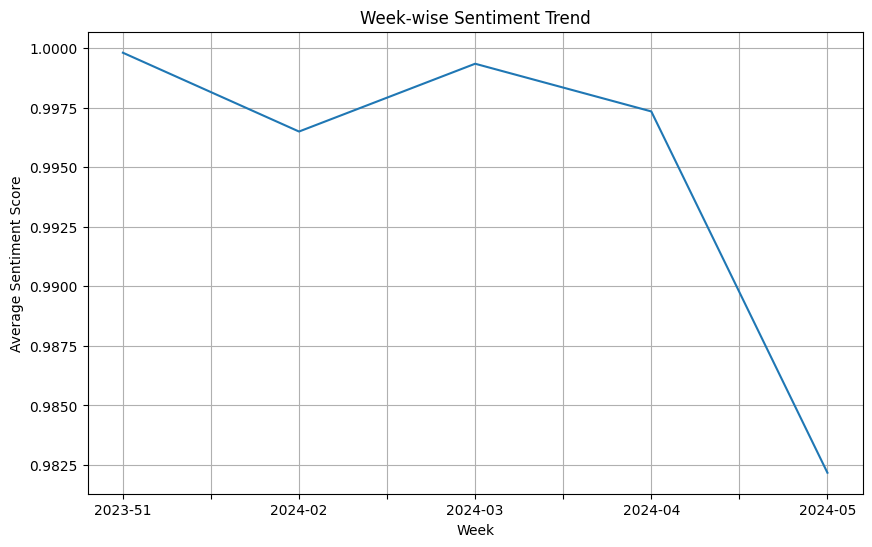

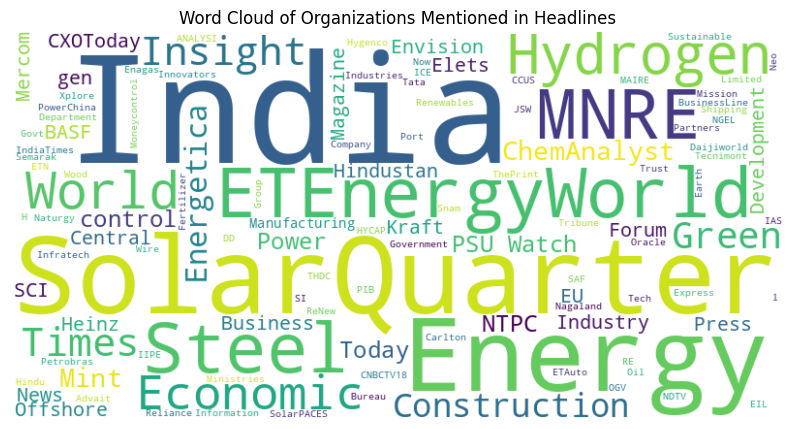

In [92]:
main()